In [1]:
#import cv2
import os

import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from pathlib import Path
from PIL import Image, ImageDraw
from tensorflow.keras import backend as K
import keras
#from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Dense, Add, Conv2D, SeparableConv2D
from tensorflow.keras.layers import BatchNormalization, AveragePooling2D
from tensorflow.keras.layers import LeakyReLU, MaxPooling2D, Flatten
from tensorflow.keras.models import Model

keras.saving.get_custom_objects().clear()

In [2]:
IMG_HEIGHT = 264
IMG_WIDTH = 640
X_FACTOR = 1
Y_FACTOR = 1
BATCH_SIZE = 128
EPOCHS = 30    # maybe mehr?
learning_rate = 0.005    # 0.003
train_dataset_path = './images/train/'
test_dataset_path = './images/test/'

In [3]:
# Function to read images names and store them in a DataFrame
def grabPaths(filepath):
    labels = [str(filepath[i]).split("/")[-1] \
              for i in range(len(filepath))]

    filepath = pd.Series(filepath, name='path').astype(str)
    
    # Concatenate filepaths and labels

    # Shuffle the DataFrame and reset index
    df = pd.DataFrame(filepath)
    
    return df

# Function to scale boxes coordinates (bacuase images are resized)
def resize_boxes(boxes):
    boxes = np.array(boxes).astype(np.float32)
    boxes = boxes * X_FACTOR
    return (np.rint(boxes)).astype(int)


# Function to draw bounding box given an image & coordinates
def plot_bbox(image, yt_box, yp_box=None, norm=False):
    # If image is normalized (/255.) reconstruct (inverse) the operation
    if norm:
        image = image * 255.
        image = image.astype("uint8")
    
    # Convert image to array if not converted
    try:
        pil_img = Image.fromarray(image)
    except:
        pil_img = Image.fromarray(image.astype('uint8'))
        
    draw_img = ImageDraw.Draw(pil_img)
    
    x1, y1, w = yt_box
    h = w
    x2, y2 = x1+w, y1+h
    draw_img.rectangle((x1, y1, x2, y2), outline='green')
    
    # If y_pred box is given, draw it
    if yp_box is not None:
        x1, y1, w = yp_box
        h = w
        x2, y2 = x1+w, y1+h
        draw_img.rectangle((x1, y1, x2, y2), outline='red')
    return pil_img


# Function to build convolutionl block
def convblock(previous_layer, n_filters, filter_windows=(3,3,3), padding='same', pool=None):
    # [DepthwiseConv -> BatchNorm -> LeakyReLU] x3 + Residual connection -> Pooling (optional)

    x = SeparableConv2D(n_filters[0], filter_windows[0], padding=padding)(previous_layer)
    x_short = x
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    x = SeparableConv2D(n_filters[1], filter_windows[1], padding=padding)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    x = SeparableConv2D(n_filters[2], filter_windows[2], padding=padding)(x)
    x = BatchNormalization()(x)
    x = Add()([x, x_short])
    x = LeakyReLU()(x)
    
    if pool == 'max':
        x = MaxPooling2D(pool_size=(2,2))(x)
    elif pool == 'avg':
        x = AveragePooling2D(pool_size=(2,2))(x)
    
    return x

# Function to show samples
def visualize_samples(datagen, row_col_len=4, figsize=None):
    figsize = figsize or np.array((row_col_len, row_col_len)) * 4
    fig, ax = plt.subplots(row_col_len*5, row_col_len, figsize=figsize)
    for i in range(row_col_len*5):
        for j in range(row_col_len):
            batch_index = np.random.randint(0, BATCH_SIZE/2)
            output_classes = np.array(datagen[batch_index][1]['class_out'])
            classes_true = np.where(output_classes == 1)[0]
            sample_index = classes_true[np.random.randint(0, classes_true.shape[0])]
            image = datagen[batch_index][0][sample_index]
            print(image.shape)
            box = datagen[batch_index][1]['box_out'][sample_index]
            plotted_box = plot_bbox(image, box, norm=True)
            ax[i,j].imshow(plotted_box)
            ax[i,j].set_axis_off()
            #ax[i,j].title.set_text(str(batch_index*BATCH_SIZE+sample_index))
    plt.show()
    


# Function to make a prediction during training
def visualize_prediction(model, data):    
    # Select a sample where an object exists
    output_classes = np.array(custom_test_gen[0][1]['class_out'])
    sample_index = np.where(output_classes == 1)[0]
    sample_index = sample_index[0] if sample_index[0] else 0 
    
    # Get image
    image = np.array([data[0][0][sample_index]])
    
    # Set y_true & y_pred for class & bounding box
    yt_box = np.array([custom_test_gen[0][1]['box_out'][sample_index]])
    yt_class = np.array([custom_test_gen[0][1]['class_out'][sample_index]])
    yp_class, yp_box = model.predict(image)

    # Plot bounding box on image & show it
    image_plotted = plot_bbox(image[0], yt_box[0], yp_box[0], norm=True) 
    plt.imshow(image_plotted)
    plt.axis('off')
    
    # Print y_true class & y_pred class
    print("Class: y_true=", yt_class, " | y_pred=", int(yp_class >= 0.5))
    plt.show()


# Function to reduce learning rate during training        
def lr_scheduler(epoch, lr):
    if epoch > 10:
        lr = lr * tf.math.exp(-0.1) #-0.15
        print(lr)
    return float(lr)


In [4]:
# Read CSV
train_dataset = pd.read_csv('./images/train/dataset.csv')
train_dataset.columns = ['path', 'ball_exists', 'x', 'y', 'w', 'h']
test_dataset = pd.read_csv('./images/test/dataset.csv')
test_dataset.columns = ['path', 'ball_exists', 'x', 'y', 'w', 'h']


# List directories of files
train_image_dir_hand = Path('./images/train')
train_filepaths_hand = list(train_image_dir_hand.glob(r'**/*.jpg'))
test_image_dir_hand = Path('./images/test')
test_filepaths_hand = list(train_image_dir_hand.glob(r'**/*.jpg'))

# Create dataframe of {paths, labels}
train_df_hand = grabPaths(train_filepaths_hand)
test_df_hand = grabPaths(test_filepaths_hand)

train_dataset['path'] = "./images/train/" + train_dataset['path']
test_dataset['path'] = "./images/test/" + test_dataset['path']


# Resize boxes, keep zeros if no object exists
train_dataset.iloc[:,2:] = resize_boxes(train_dataset.iloc[:,2:])
test_dataset.iloc[:,2:] = resize_boxes(test_dataset.iloc[:,2:])

[Text(0.5, 0, 'Object exists in image'), Text(0, 0.5, 'No. of Image')]

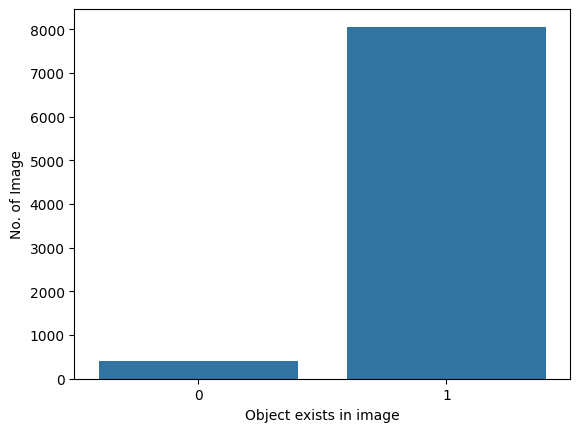

In [5]:
ax = sns.countplot(x='ball_exists', data=train_dataset)
ax.set(xlabel='Object exists in image', ylabel='No. of Image')

In [6]:
# balance dataset (undersampling)
# balls = dataset[dataset['ball_exists'] == 1]
# noballs = dataset[dataset['ball_exists'] == 0]
# balls = balls.sample(frac=0.75).reset_index(drop=True)

# # merge balanced classes & shuffle
# train_df = pd.concat((balls, noballs)).sample(frac=1.).reset_index(drop=True)

# train_df, test_df = train_test_split(train_df, test_size=0.2)

# print(f"No. Training Samples: {train_df.shape[0]}\nNo. Validation Samples: {test_df.shape[0]}")

In [7]:
# Create custom Generator for multiple output models
class MultiOutputGen(tf.keras.utils.Sequence):
    def __init__(self, input_gen, output_gen):
        self.inpgen = input_gen
        self.outgen = output_gen
#         assert len(input_gen) == len(output_gen)

    def __len__(self):
        return len(self.inpgen)

    def __getitem__(self, i):
        images = self.inpgen[i]
        start = i * images.shape[0]
        end = (i+1) * images.shape[0]
        classes_num = self.outgen.iloc[start:end,0].values
        x = self.outgen.iloc[start:end,1]
        y = self.outgen.iloc[start:end,2]
        w = self.outgen.iloc[start:end,3]
#         h = self.outgen.iloc[start:end,4]
        return images, {'class_out':classes_num, 'box_out':np.array([x, y, w]).T}

    def on_epoch_end(self):
        self.inpgen.on_epoch_end()
    
# Class to visualize predictions during training
class ConvergenceVisualization(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        global custom_test_gen
        visualize_prediction(self.model, custom_test_gen)

In [8]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    brightness_range=(0.8, 1.2),
    rescale = 1./255.,
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale = 1./255.,
)

train_images = train_generator.flow_from_dataframe(
    dataframe=train_dataset,
    x_col='path',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    color_mode='rgb',
    class_mode=None,
    batch_size=BATCH_SIZE,
    shuffle=False,
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_dataset,
    x_col='path',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    color_mode='rgb',
    class_mode=None,
    batch_size=BATCH_SIZE,
    shuffle=False,
)

# Create multi-output generator
custom_train_gen = MultiOutputGen(train_images, train_dataset.iloc[:,1:])
custom_test_gen = MultiOutputGen(test_images, test_dataset.iloc[:,1:])

Found 8458 validated image filenames.
Found 637 validated image filenames.


(264, 640, 3)
(264, 640, 3)
(264, 640, 3)
(264, 640, 3)
(264, 640, 3)
(264, 640, 3)
(264, 640, 3)
(264, 640, 3)
(264, 640, 3)
(264, 640, 3)
(264, 640, 3)
(264, 640, 3)
(264, 640, 3)
(264, 640, 3)
(264, 640, 3)
(264, 640, 3)
(264, 640, 3)
(264, 640, 3)
(264, 640, 3)
(264, 640, 3)


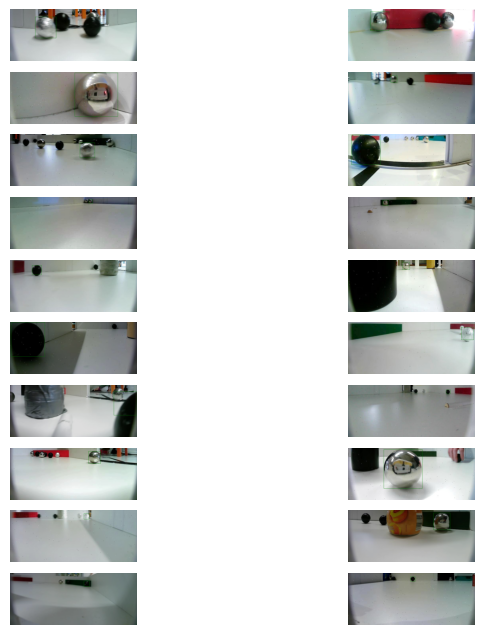

In [9]:
visualize_samples(custom_train_gen, 2)

In [10]:
# BEST MODEL

inp = Input(shape=(IMG_HEIGHT,IMG_WIDTH,3), name='image')

X = SeparableConv2D(64, (7,7), strides=2, padding='valid')(inp)
X = MaxPooling2D(pool_size=(2,2), strides=2)(X)

X = SeparableConv2D(192, (3,3), strides=1, padding='same')(X)
X = MaxPooling2D(pool_size=(2,2), strides=2)(X)

X = convblock(X, [16, 16, 16], pool='max')
X = convblock(X, [32, 32, 32], pool='max')
X = convblock(X, [64, 64, 64], pool='max')
X = convblock(X, [128, 128, 128], pool='max')
X = convblock(X, [256, 256, 256])

X = Flatten()(X)
boxX = Dense(512)(X)
boxX = LeakyReLU()(boxX)

classX = Dense(128)(X)
classX = LeakyReLU()(classX)

box_out = Dense(3, name='box_out')(boxX)
class_out = Dense(1, name='class_out', activation='sigmoid')(classX)


model = Model(inp, [class_out, box_out])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ image (InputLayer)            │ (None, 264, 640, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ separable_conv2d              │ (None, 129, 317, 64)      │             403 │ image[0][0]                │
│ (SeparableConv2D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d (MaxPooling2D)  │ (None, 64, 158, 64)       │               0 │ separable_conv2d[0][0]     │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ separable_conv2d_1            │ (None, 64, 158, 192)      │          13,056 │ max_pooling2d[0][0]        │
│ (SeparableConv2D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_1               │ (None, 32, 79, 192)       │               0 │ separable_conv2d_1[0][0]   │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ separable_conv2d_2            │ (None, 32, 79, 16)        │           4,816 │ max_pooling2d_1[0][0]      │
│ (SeparableConv2D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization           │ (None, 32, 79, 16)        │              64 │ separable_conv2d_2[0][0]   │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ leaky_re_lu (LeakyReLU)       │ (None, 32, 79, 16)        │               0 │ batch_normalization[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ separable_conv2d_3            │ (None, 32, 79, 16)        │             416 │ leaky_re_lu[0][0]          │
│ (SeparableConv2D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_1         │ (None, 32, 79, 16)        │              64 │ separable_conv2d_3[0][0]   │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ leaky_re_lu_1 (LeakyReLU)     │ (None, 32, 79, 16)        │               0 │ batch_normalization_1[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ separable_conv2d_4            │ (None, 32, 79, 16)        │             416 │ leaky_re_lu_1[0][0]        │
│ (SeparableConv2D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_2         │ (None, 32, 79, 16)        │              64 │ separable_conv2d_4[0][0]   │
│ (BatchNormalization)          │                           │               

 Total params: 1,567,927 (5.98 MB)

 Trainable params: 1,564,951 (5.97 MB)

 Non-trainable params: 2,976 (11.62 KB)

In [11]:
adam = tf.keras.optimizers.Adam(learning_rate=learning_rate)

# Function to calculate MSE Loss function
# for samples where object exists
@keras.saving.register_keras_serializable(package="custom_package", name="custom_mse")
def custom_mse(y_true, y_pred):
    mask = K.not_equal(K.sum(y_true, axis=1), 0.0)
    y_true_custom = y_true[mask]
    y_pred_custom = y_pred[mask]
    mse = tf.keras.losses.MeanSquaredError()
    result = mse(y_true_custom, y_pred_custom) # * 0.3
    return result

model.compile(
    loss={
        "box_out":custom_mse,
        'class_out':'binary_crossentropy'
    },
    metrics={
        'class_out':'accuracy'
    },
    optimizer=adam
)

C:\Users\Salkin\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/stepep - box_out_loss: 12198.1113 - class_out_accuracy: 0.9072 - class_out_loss: 2.1640 - loss: 12177.0703 
Class: y_true= [1]  | y_pred= 1


C:\Users\Salkin\AppData\Local\Temp\ipykernel_29052\4120968420.py:118: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print("Class: y_true=", yt_class, " | y_pred=", int(yp_class >= 0.5))


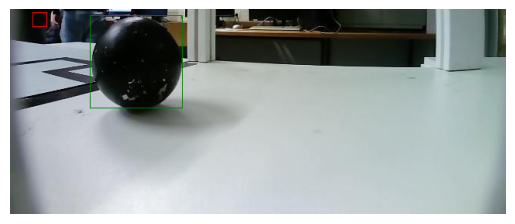

67/67 ━━━━━━━━━━━━━━━━━━━━ 75s 1s/step - box_out_loss: 12144.1396 - class_out_accuracy: 0.9071 - class_out_loss: 2.1939 - loss: 12122.3115 - val_box_out_loss: 13872.4092 - val_class_out_accuracy: 0.3721 - val_class_out_loss: 1.9156 - val_loss: 13939.6543 - learning_rate: 0.0050
Epoch 2/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/steptep - box_out_loss: 6131.5000 - class_out_accuracy: 0.9632 - class_out_loss: 0.4362 - loss: 6019.0854      
Class: y_true= [1]  | y_pred= 1


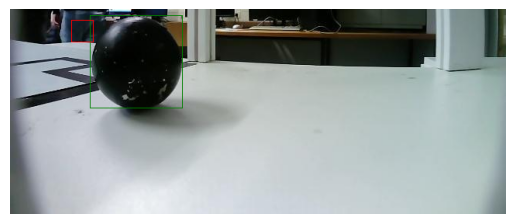

67/67 ━━━━━━━━━━━━━━━━━━━━ 67s 999ms/step - box_out_loss: 6125.7588 - class_out_accuracy: 0.9628 - class_out_loss: 0.4404 - loss: 6013.1880 - val_box_out_loss: 10700.4805 - val_class_out_accuracy: 0.3721 - val_class_out_loss: 2.0854 - val_loss: 10752.9541 - learning_rate: 0.0050
Epoch 3/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/steptep - box_out_loss: 5164.1123 - class_out_accuracy: 0.9036 - class_out_loss: 0.4199 - loss: 5080.1782  
Class: y_true= [1]  | y_pred= 1


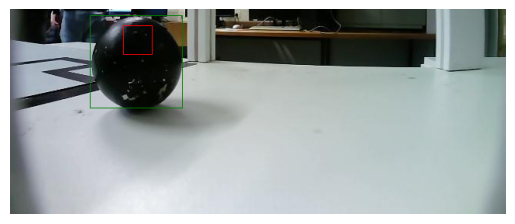

67/67 ━━━━━━━━━━━━━━━━━━━━ 68s 1s/step - box_out_loss: 5163.8457 - class_out_accuracy: 0.9038 - class_out_loss: 0.4183 - loss: 5079.4590 - val_box_out_loss: 7554.9150 - val_class_out_accuracy: 0.3721 - val_class_out_loss: 5.8173 - val_loss: 7596.2969 - learning_rate: 0.0050
Epoch 4/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/steptep - box_out_loss: 4490.7036 - class_out_accuracy: 0.9761 - class_out_loss: 0.4084 - loss: 4477.9238   
Class: y_true= [1]  | y_pred= 1


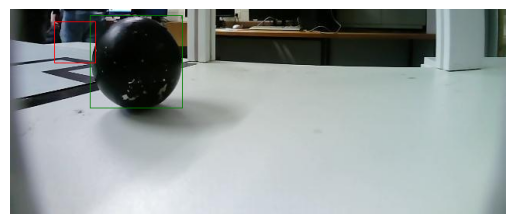

67/67 ━━━━━━━━━━━━━━━━━━━━ 69s 1s/step - box_out_loss: 4487.7256 - class_out_accuracy: 0.9757 - class_out_loss: 0.4117 - loss: 4473.3677 - val_box_out_loss: 4821.3960 - val_class_out_accuracy: 0.3721 - val_class_out_loss: 1.1725 - val_loss: 4845.2734 - learning_rate: 0.0050
Epoch 5/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/steptep - box_out_loss: 3980.8318 - class_out_accuracy: 0.9288 - class_out_loss: 0.3073 - loss: 3900.5815  
Class: y_true= [1]  | y_pred= 1


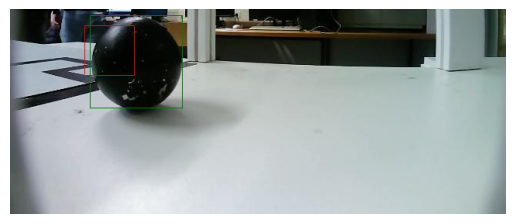

67/67 ━━━━━━━━━━━━━━━━━━━━ 67s 994ms/step - box_out_loss: 3980.8328 - class_out_accuracy: 0.9288 - class_out_loss: 0.3068 - loss: 3899.4331 - val_box_out_loss: 2359.3562 - val_class_out_accuracy: 0.3721 - val_class_out_loss: 10.0508 - val_loss: 2380.4927 - learning_rate: 0.0050
Epoch 6/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/steptep - box_out_loss: 3453.8665 - class_out_accuracy: 0.9647 - class_out_loss: 0.6445 - loss: 3279.7188     
Class: y_true= [1]  | y_pred= 1


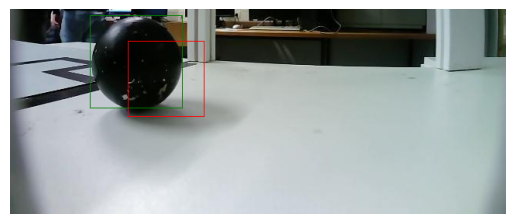

67/67 ━━━━━━━━━━━━━━━━━━━━ 66s 985ms/step - box_out_loss: 3453.7893 - class_out_accuracy: 0.9645 - class_out_loss: 0.6437 - loss: 3280.1428 - val_box_out_loss: 1573.7601 - val_class_out_accuracy: 0.4521 - val_class_out_loss: 0.8724 - val_loss: 1582.0419 - learning_rate: 0.0050
Epoch 7/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/steptep - box_out_loss: 3022.8840 - class_out_accuracy: 0.9430 - class_out_loss: 0.2881 - loss: 2821.1138  
Class: y_true= [1]  | y_pred= 1


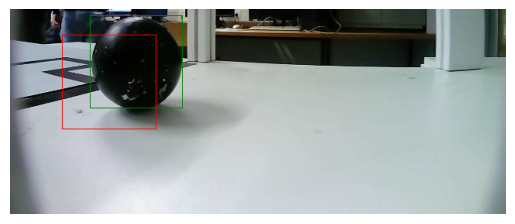

67/67 ━━━━━━━━━━━━━━━━━━━━ 66s 987ms/step - box_out_loss: 3021.9309 - class_out_accuracy: 0.9429 - class_out_loss: 0.2891 - loss: 2820.5332 - val_box_out_loss: 1882.8330 - val_class_out_accuracy: 0.3721 - val_class_out_loss: 1.9182 - val_loss: 1893.6130 - learning_rate: 0.0050
Epoch 8/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/steptep - box_out_loss: 2339.5916 - class_out_accuracy: 0.8460 - class_out_loss: 0.3868 - loss: 2323.9810  
Class: y_true= [1]  | y_pred= 1


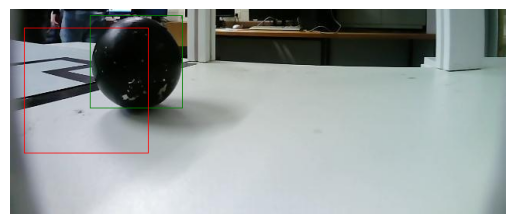

67/67 ━━━━━━━━━━━━━━━━━━━━ 69s 1s/step - box_out_loss: 2342.4243 - class_out_accuracy: 0.8474 - class_out_loss: 0.3851 - loss: 2324.8938 - val_box_out_loss: 2741.5417 - val_class_out_accuracy: 0.3721 - val_class_out_loss: 2.5099 - val_loss: 2756.9556 - learning_rate: 0.0050
Epoch 9/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/steptep - box_out_loss: 3429.4404 - class_out_accuracy: 0.9619 - class_out_loss: 0.2118 - loss: 3163.3259  
Class: y_true= [1]  | y_pred= 1


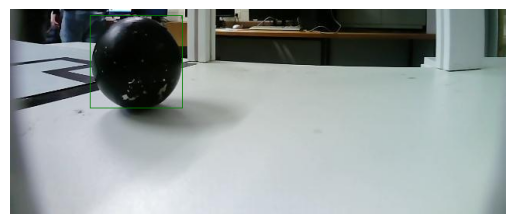

67/67 ━━━━━━━━━━━━━━━━━━━━ 69s 1s/step - box_out_loss: 3439.5720 - class_out_accuracy: 0.9614 - class_out_loss: 0.2134 - loss: 3174.6057 - val_box_out_loss: 36488.3750 - val_class_out_accuracy: 0.3752 - val_class_out_loss: 7.2009 - val_loss: 36667.3984 - learning_rate: 0.0050
Epoch 10/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/steptep - box_out_loss: 3900.0405 - class_out_accuracy: 0.9587 - class_out_loss: 0.1968 - loss: 3581.9124     
Class: y_true= [1]  | y_pred= 1


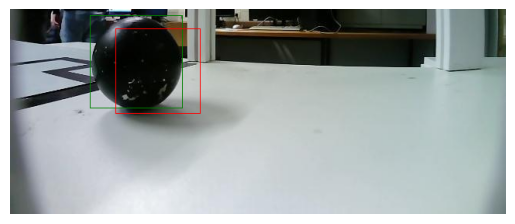

67/67 ━━━━━━━━━━━━━━━━━━━━ 69s 1s/step - box_out_loss: 3892.9138 - class_out_accuracy: 0.9584 - class_out_loss: 0.1978 - loss: 3576.7366 - val_box_out_loss: 1807.5785 - val_class_out_accuracy: 0.3721 - val_class_out_loss: 4.2448 - val_loss: 1820.3240 - learning_rate: 0.0050
Epoch 11/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/steptep - box_out_loss: 2315.5857 - class_out_accuracy: 0.9333 - class_out_loss: 0.4197 - loss: 2308.6130  
Class: y_true= [1]  | y_pred= 1


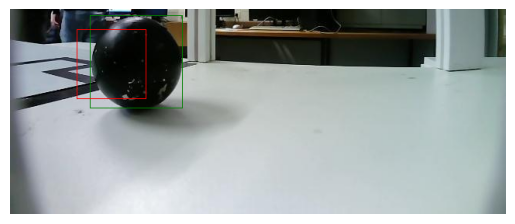

67/67 ━━━━━━━━━━━━━━━━━━━━ 67s 996ms/step - box_out_loss: 2317.6907 - class_out_accuracy: 0.9336 - class_out_loss: 0.4180 - loss: 2308.4333 - val_box_out_loss: 1451.5319 - val_class_out_accuracy: 0.3721 - val_class_out_loss: 1.3393 - val_loss: 1459.7035 - learning_rate: 0.0050
tf.Tensor(0.004524187, shape=(), dtype=float32)
Epoch 12/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/steptep - box_out_loss: 1746.5995 - class_out_accuracy: 0.9753 - class_out_loss: 0.1490 - loss: 1739.3693  
Class: y_true= [1]  | y_pred= 1


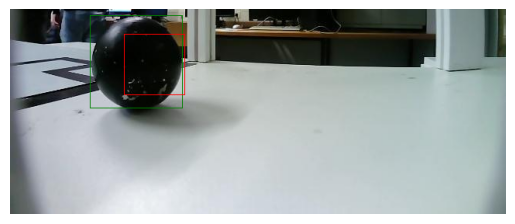

67/67 ━━━━━━━━━━━━━━━━━━━━ 67s 990ms/step - box_out_loss: 1748.0662 - class_out_accuracy: 0.9750 - class_out_loss: 0.1500 - loss: 1738.5591 - val_box_out_loss: 2223.3049 - val_class_out_accuracy: 0.3721 - val_class_out_loss: 1.3479 - val_loss: 2235.1196 - learning_rate: 0.0045
tf.Tensor(0.004093654, shape=(), dtype=float32)
Epoch 13/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/steptep - box_out_loss: 1559.9818 - class_out_accuracy: 0.9850 - class_out_loss: 0.1065 - loss: 1403.0640 
Class: y_true= [1]  | y_pred= 1


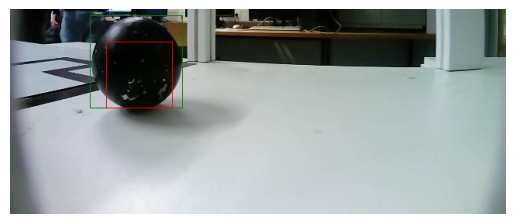

67/67 ━━━━━━━━━━━━━━━━━━━━ 68s 1s/step - box_out_loss: 1559.9818 - class_out_accuracy: 0.9845 - class_out_loss: 0.1083 - loss: 1402.6936 - val_box_out_loss: 1310.3778 - val_class_out_accuracy: 0.3721 - val_class_out_loss: 1.8671 - val_loss: 1318.4108 - learning_rate: 0.0041
tf.Tensor(0.0037040913, shape=(), dtype=float32)
Epoch 14/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/steptep - box_out_loss: 1260.7034 - class_out_accuracy: 0.9621 - class_out_loss: 0.2691 - loss: 1164.6414  
Class: y_true= [1]  | y_pred= 1


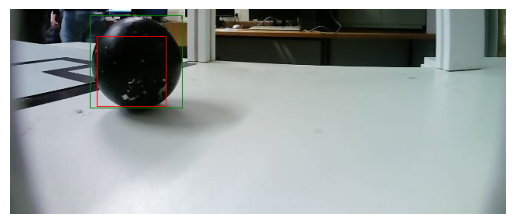

67/67 ━━━━━━━━━━━━━━━━━━━━ 68s 1s/step - box_out_loss: 1261.5978 - class_out_accuracy: 0.9620 - class_out_loss: 0.2695 - loss: 1164.4281 - val_box_out_loss: 1716.3961 - val_class_out_accuracy: 0.3721 - val_class_out_loss: 2.1857 - val_loss: 1726.6589 - learning_rate: 0.0037
tf.Tensor(0.0033516004, shape=(), dtype=float32)
Epoch 15/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/steptep - box_out_loss: 920.9893 - class_out_accuracy: 0.9244 - class_out_loss: 0.2329 - loss: 852.5413    
Class: y_true= [1]  | y_pred= 1


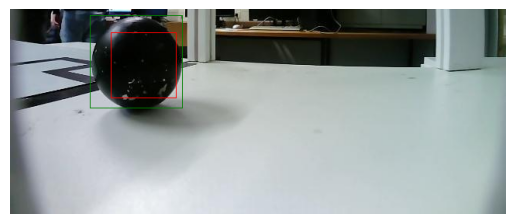

67/67 ━━━━━━━━━━━━━━━━━━━━ 68s 1s/step - box_out_loss: 922.6631 - class_out_accuracy: 0.9247 - class_out_loss: 0.2321 - loss: 853.2513 - val_box_out_loss: 1502.8674 - val_class_out_accuracy: 0.3721 - val_class_out_loss: 3.6799 - val_loss: 1513.6152 - learning_rate: 0.0034
tf.Tensor(0.0030326534, shape=(), dtype=float32)
Epoch 16/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/steptep - box_out_loss: 955.8769 - class_out_accuracy: 0.9185 - class_out_loss: 0.4630 - loss: 801.8136  
Class: y_true= [1]  | y_pred= 1


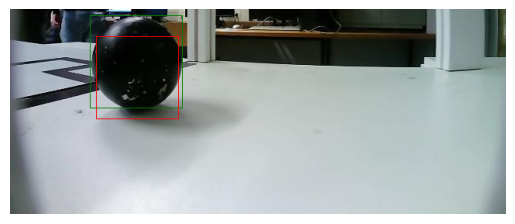

67/67 ━━━━━━━━━━━━━━━━━━━━ 68s 1s/step - box_out_loss: 956.8071 - class_out_accuracy: 0.9190 - class_out_loss: 0.4602 - loss: 803.4186 - val_box_out_loss: 1200.2994 - val_class_out_accuracy: 0.3721 - val_class_out_loss: 1.6962 - val_loss: 1207.6438 - learning_rate: 0.0030
tf.Tensor(0.0027440584, shape=(), dtype=float32)
Epoch 17/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/steptep - box_out_loss: 794.1631 - class_out_accuracy: 0.9464 - class_out_loss: 0.2075 - loss: 726.6121  
Class: y_true= [1]  | y_pred= 1


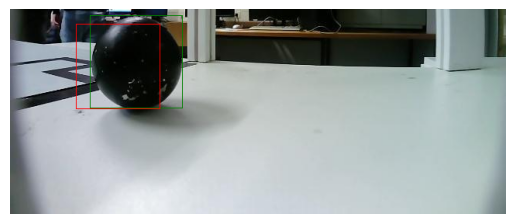

67/67 ━━━━━━━━━━━━━━━━━━━━ 67s 995ms/step - box_out_loss: 799.5375 - class_out_accuracy: 0.9465 - class_out_loss: 0.2074 - loss: 730.1785 - val_box_out_loss: 1285.0647 - val_class_out_accuracy: 0.3721 - val_class_out_loss: 1.2938 - val_loss: 1292.4070 - learning_rate: 0.0027
tf.Tensor(0.0024829267, shape=(), dtype=float32)
Epoch 18/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/steptep - box_out_loss: 1276.8230 - class_out_accuracy: 0.9780 - class_out_loss: 0.1368 - loss: 1235.2935  
Class: y_true= [1]  | y_pred= 1


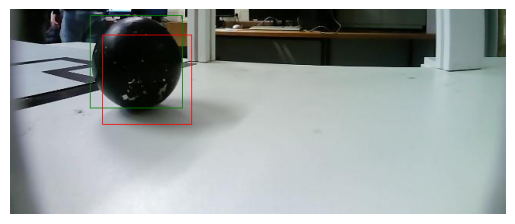

67/67 ━━━━━━━━━━━━━━━━━━━━ 68s 1s/step - box_out_loss: 1276.4440 - class_out_accuracy: 0.9776 - class_out_loss: 0.1379 - loss: 1233.2566 - val_box_out_loss: 1497.9043 - val_class_out_accuracy: 0.3721 - val_class_out_loss: 1.4803 - val_loss: 1506.4349 - learning_rate: 0.0025
tf.Tensor(0.002246645, shape=(), dtype=float32)
Epoch 19/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/steptep - box_out_loss: 921.3035 - class_out_accuracy: 0.9315 - class_out_loss: 0.2149 - loss: 658.4658  
Class: y_true= [1]  | y_pred= 1


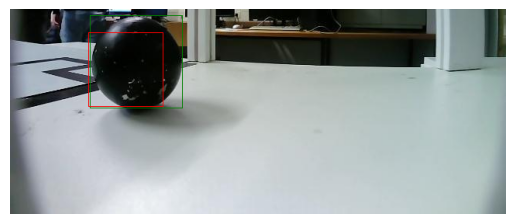

67/67 ━━━━━━━━━━━━━━━━━━━━ 68s 1s/step - box_out_loss: 919.1810 - class_out_accuracy: 0.9318 - class_out_loss: 0.2140 - loss: 658.1268 - val_box_out_loss: 1237.5817 - val_class_out_accuracy: 0.3721 - val_class_out_loss: 2.3385 - val_loss: 1245.7416 - learning_rate: 0.0022
tf.Tensor(0.0020328485, shape=(), dtype=float32)
Epoch 20/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/steptep - box_out_loss: 686.6257 - class_out_accuracy: 0.9723 - class_out_loss: 0.1197 - loss: 554.5192  
Class: y_true= [1]  | y_pred= 1


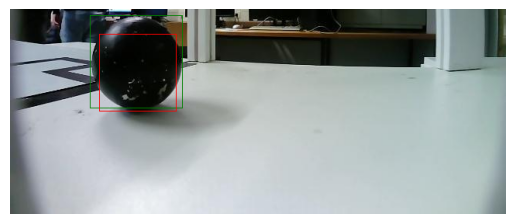

67/67 ━━━━━━━━━━━━━━━━━━━━ 68s 1s/step - box_out_loss: 687.6674 - class_out_accuracy: 0.9720 - class_out_loss: 0.1205 - loss: 555.1591 - val_box_out_loss: 1166.0375 - val_class_out_accuracy: 0.3721 - val_class_out_loss: 1.1600 - val_loss: 1172.6860 - learning_rate: 0.0020
tf.Tensor(0.0018393975, shape=(), dtype=float32)
Epoch 21/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/steptep - box_out_loss: 958.8774 - class_out_accuracy: 0.8921 - class_out_loss: 0.2602 - loss: 515.7369  
Class: y_true= [1]  | y_pred= 1


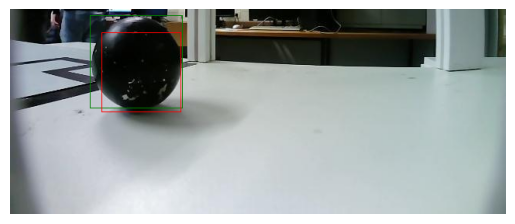

67/67 ━━━━━━━━━━━━━━━━━━━━ 68s 1s/step - box_out_loss: 954.6142 - class_out_accuracy: 0.8930 - class_out_loss: 0.2583 - loss: 515.5807 - val_box_out_loss: 1248.0018 - val_class_out_accuracy: 0.3721 - val_class_out_loss: 2.7605 - val_loss: 1256.6324 - learning_rate: 0.0018
tf.Tensor(0.0016643556, shape=(), dtype=float32)
Epoch 22/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/steptep - box_out_loss: 428.6635 - class_out_accuracy: 0.9828 - class_out_loss: 0.0668 - loss: 390.6572  
Class: y_true= [1]  | y_pred= 1


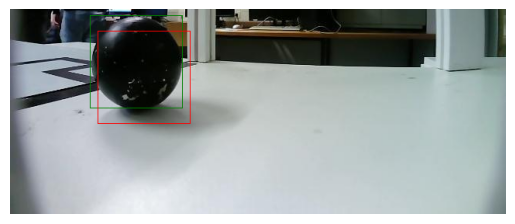

67/67 ━━━━━━━━━━━━━━━━━━━━ 67s 1s/step - box_out_loss: 429.6846 - class_out_accuracy: 0.9824 - class_out_loss: 0.0684 - loss: 390.8990 - val_box_out_loss: 1090.8483 - val_class_out_accuracy: 0.3721 - val_class_out_loss: 1.1963 - val_loss: 1097.1790 - learning_rate: 0.0017
tf.Tensor(0.0015059713, shape=(), dtype=float32)
Epoch 23/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/steptep - box_out_loss: 391.3218 - class_out_accuracy: 0.9453 - class_out_loss: 0.1628 - loss: 382.6493  
Class: y_true= [1]  | y_pred= 1


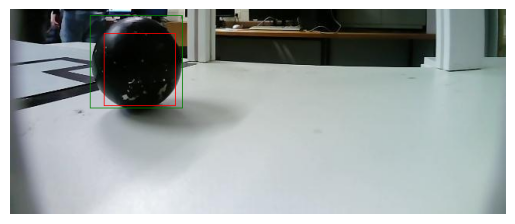

67/67 ━━━━━━━━━━━━━━━━━━━━ 68s 1s/step - box_out_loss: 391.4770 - class_out_accuracy: 0.9454 - class_out_loss: 0.1627 - loss: 382.3282 - val_box_out_loss: 1360.6520 - val_class_out_accuracy: 0.3721 - val_class_out_loss: 1.5847 - val_loss: 1368.6403 - learning_rate: 0.0015
tf.Tensor(0.0013626592, shape=(), dtype=float32)
Epoch 24/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/steptep - box_out_loss: 383.5048 - class_out_accuracy: 0.9646 - class_out_loss: 0.1269 - loss: 361.5110  
Class: y_true= [1]  | y_pred= 1


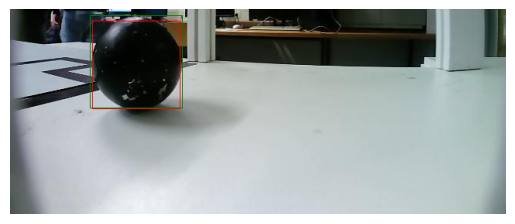

67/67 ━━━━━━━━━━━━━━━━━━━━ 68s 1s/step - box_out_loss: 384.9342 - class_out_accuracy: 0.9644 - class_out_loss: 0.1273 - loss: 361.4384 - val_box_out_loss: 1304.9567 - val_class_out_accuracy: 0.3721 - val_class_out_loss: 1.8040 - val_loss: 1312.9010 - learning_rate: 0.0014
tf.Tensor(0.001232985, shape=(), dtype=float32)
Epoch 25/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/steptep - box_out_loss: 327.9816 - class_out_accuracy: 0.8885 - class_out_loss: 0.2948 - loss: 327.3614  
Class: y_true= [1]  | y_pred= 1


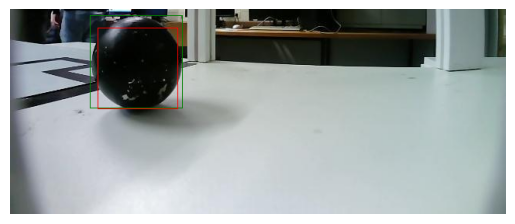

67/67 ━━━━━━━━━━━━━━━━━━━━ 68s 1s/step - box_out_loss: 328.9238 - class_out_accuracy: 0.8895 - class_out_loss: 0.2925 - loss: 327.4131 - val_box_out_loss: 1175.9377 - val_class_out_accuracy: 0.3721 - val_class_out_loss: 2.5320 - val_loss: 1184.0006 - learning_rate: 0.0012
tf.Tensor(0.001115651, shape=(), dtype=float32)
Epoch 26/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/steptep - box_out_loss: 389.3569 - class_out_accuracy: 0.9838 - class_out_loss: 0.0652 - loss: 295.4626  
Class: y_true= [1]  | y_pred= 1


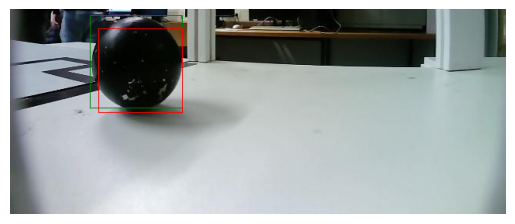

67/67 ━━━━━━━━━━━━━━━━━━━━ 69s 1s/step - box_out_loss: 388.5944 - class_out_accuracy: 0.9834 - class_out_loss: 0.0665 - loss: 295.3368 - val_box_out_loss: 1156.2979 - val_class_out_accuracy: 0.3846 - val_class_out_loss: 1.1624 - val_loss: 1162.9027 - learning_rate: 0.0011
tf.Tensor(0.0010094828, shape=(), dtype=float32)
Epoch 27/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/steptep - box_out_loss: 239.9129 - class_out_accuracy: 0.9450 - class_out_loss: 0.1656 - loss: 226.6225  
Class: y_true= [1]  | y_pred= 1


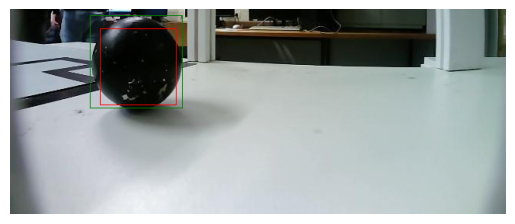

67/67 ━━━━━━━━━━━━━━━━━━━━ 65s 961ms/step - box_out_loss: 240.2412 - class_out_accuracy: 0.9452 - class_out_loss: 0.1651 - loss: 226.7207 - val_box_out_loss: 1242.8047 - val_class_out_accuracy: 0.3721 - val_class_out_loss: 2.4211 - val_loss: 1251.0718 - learning_rate: 0.0010
tf.Tensor(0.0009134178, shape=(), dtype=float32)
Epoch 28/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/steptep - box_out_loss: 235.7391 - class_out_accuracy: 0.9916 - class_out_loss: 0.0349 - loss: 222.1639 
Class: y_true= [1]  | y_pred= 1


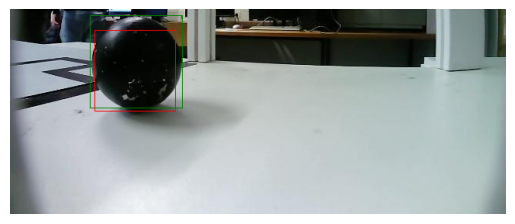

67/67 ━━━━━━━━━━━━━━━━━━━━ 64s 950ms/step - box_out_loss: 235.7870 - class_out_accuracy: 0.9911 - class_out_loss: 0.0365 - loss: 222.0205 - val_box_out_loss: 1164.4686 - val_class_out_accuracy: 0.3925 - val_class_out_loss: 1.1405 - val_loss: 1171.0898 - learning_rate: 9.1342e-04
tf.Tensor(0.0008264946, shape=(), dtype=float32)
Epoch 29/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/steptep - box_out_loss: 184.4393 - class_out_accuracy: 0.9491 - class_out_loss: 0.1646 - loss: 178.5226  
Class: y_true= [1]  | y_pred= 1


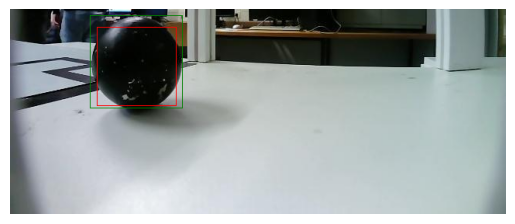

67/67 ━━━━━━━━━━━━━━━━━━━━ 64s 956ms/step - box_out_loss: 184.8086 - class_out_accuracy: 0.9493 - class_out_loss: 0.1639 - loss: 178.6727 - val_box_out_loss: 1226.1774 - val_class_out_accuracy: 0.3721 - val_class_out_loss: 2.4702 - val_loss: 1234.4152 - learning_rate: 8.2649e-04
tf.Tensor(0.00074784324, shape=(), dtype=float32)
Epoch 30/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/steptep - box_out_loss: 191.3786 - class_out_accuracy: 0.9491 - class_out_loss: 0.1595 - loss: 178.6190 
Class: y_true= [1]  | y_pred= 1


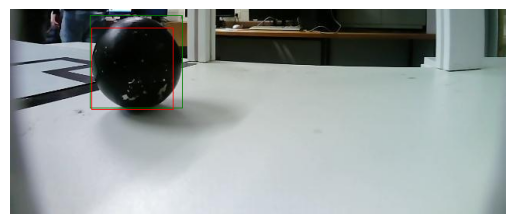

67/67 ━━━━━━━━━━━━━━━━━━━━ 64s 956ms/step - box_out_loss: 191.4813 - class_out_accuracy: 0.9492 - class_out_loss: 0.1591 - loss: 178.6279 - val_box_out_loss: 1156.7632 - val_class_out_accuracy: 0.3799 - val_class_out_loss: 1.6856 - val_loss: 1163.8912 - learning_rate: 7.4784e-04


In [12]:
history = model.fit(
    custom_train_gen,
    epochs=EPOCHS,
    validation_data=custom_test_gen,
    callbacks=[
        tf.keras.callbacks.LearningRateScheduler(lr_scheduler),
        ConvergenceVisualization()
    ]
)

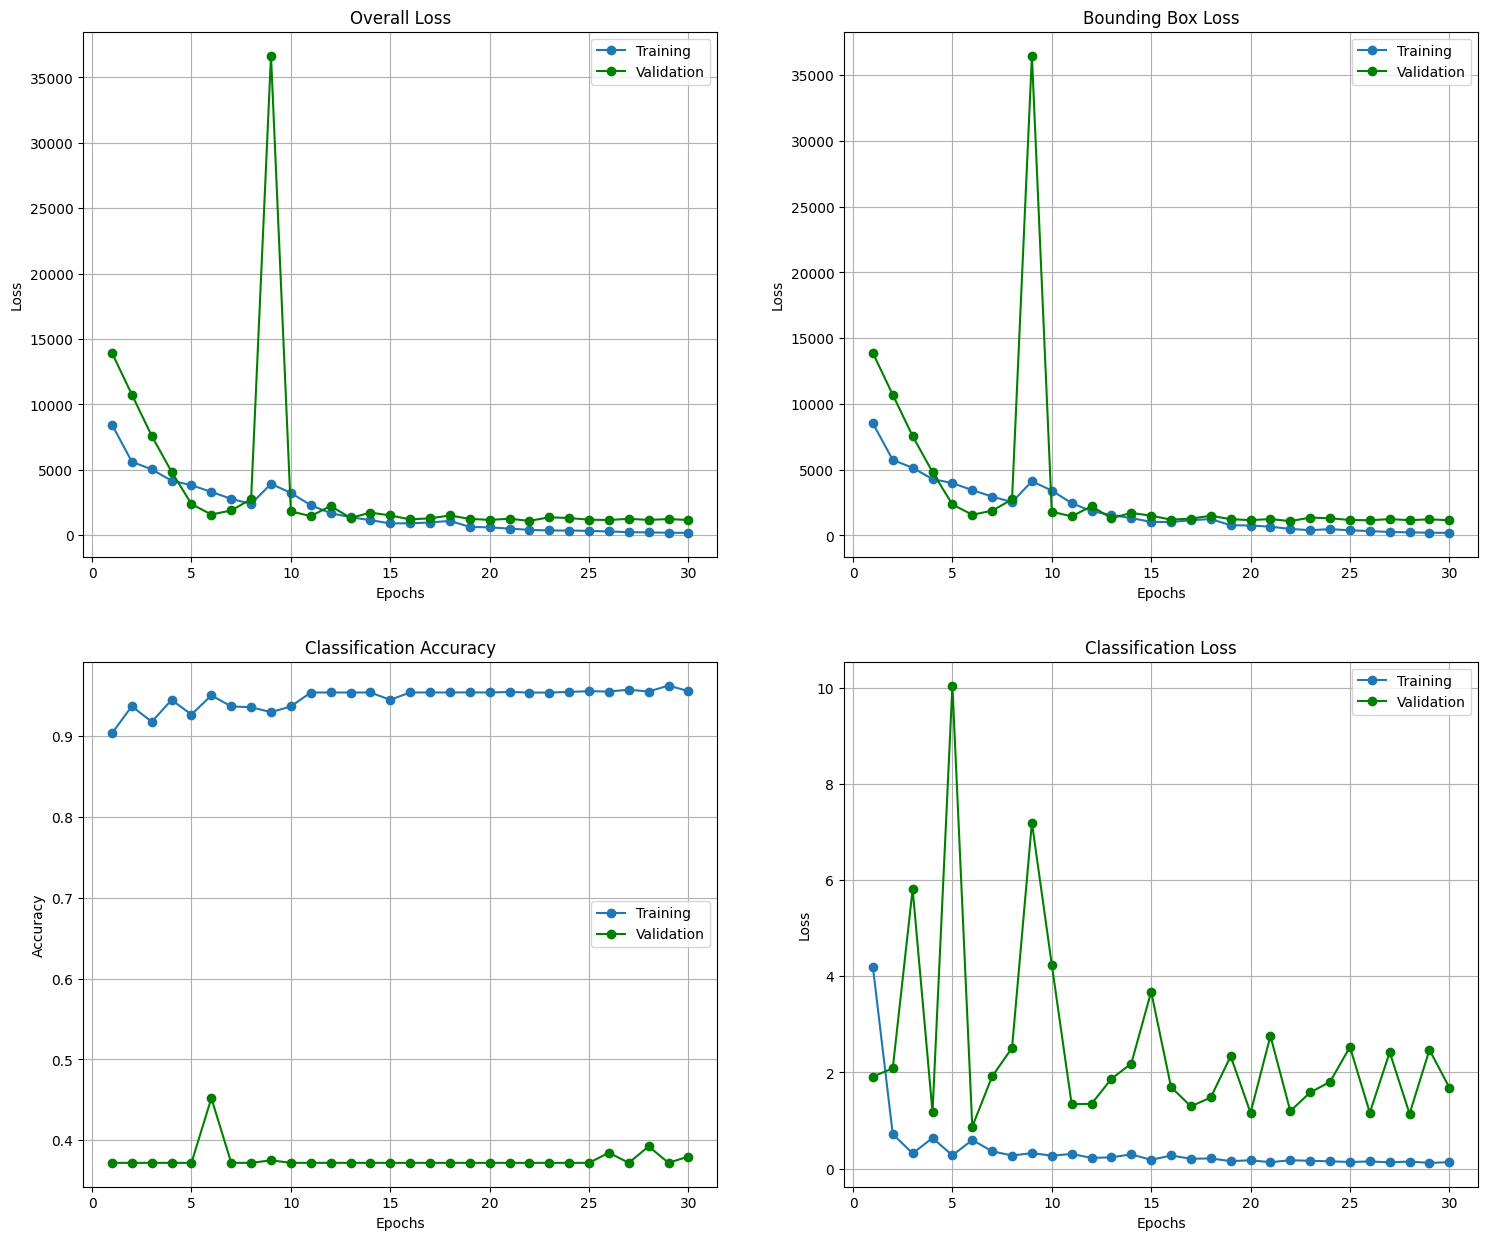

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [13]:
# Accuracy & Loss Visualization

#  Overall Loss
train_overall_loss = history.history['loss']
val_overall_loss = history.history['val_loss']

# Classification Accuracy
train_classification_acc = history.history['class_out_accuracy']
val_classification_acc = history.history['val_class_out_accuracy']

# Classification Loss
train_classification_loss = history.history['class_out_loss']
val_classification_loss = history.history['val_class_out_loss']

# Bounding Box Loss
train_bbox_loss = history.history['box_out_loss']
val_bbox_loss = history.history['val_box_out_loss']

epochs = range(1, len(history.history['loss'])+1)

f, ax = plt.subplots(nrows=2,ncols=2,figsize=(18,15))
    
ax[0,0].plot(epochs, train_overall_loss,  marker='o', label='Training')
ax[0,0].plot(epochs, val_overall_loss, marker='o', color = 'green', label='Validation')
ax[0,0].set_title('Overall Loss')
ax[0,0].set_xlabel('Epochs')
ax[0,0].set_ylabel('Loss')
ax[0,0].legend(loc='best')
ax[0,0].grid(True)

ax[0,1].plot(epochs, train_bbox_loss, marker='o', label='Training')
ax[0,1].plot(epochs, val_bbox_loss, marker='o', color = 'green', label='Validation')
ax[0,1].set_title('Bounding Box Loss')
ax[0,1].set_xlabel('Epochs')
ax[0,1].set_ylabel('Loss')
ax[0,1].legend(loc='best')
ax[0,1].grid(True)



ax[1,0].plot(epochs, train_classification_acc,  marker='o', label='Training')
ax[1,0].plot(epochs, val_classification_acc, marker='o', color = 'green', label='Validation')
ax[1,0].set_title('Classification Accuracy')
ax[1,0].set_xlabel('Epochs')
ax[1,0].set_ylabel('Accuracy')
ax[1,0].legend(loc='best')
ax[1,0].grid(True)

ax[1,1].plot(epochs, train_classification_loss, marker='o', label='Training')
ax[1,1].plot(epochs, val_classification_loss, marker='o', color = 'green', label='Validation')
ax[1,1].set_title('Classification Loss')
ax[1,1].set_xlabel('Epochs')
ax[1,1].set_ylabel('Loss')
ax[1,1].legend(loc='best')
ax[1,1].grid(True)

plt.show()
f.savefig('LossAndAccuracy.eps', format='eps')
plt.close()

In [14]:
#model.save("test1 ball detection.h5")
model.save("ball_detection_V2.keras")

converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
open("ball_detection.tflite", "wb").write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\Salkin\AppData\Local\Temp\tmpztncne0k\assets


INFO:tensorflow:Assets written to: C:\Users\Salkin\AppData\Local\Temp\tmpztncne0k\assets


Saved artifact at 'C:\Users\Salkin\AppData\Local\Temp\tmpztncne0k'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 264, 640, 3), dtype=tf.float32, name='image')
Output Type:
  List[TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)]
Captures:
  2447333077072: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2447333074000: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2447383372304: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2447383371728: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2447383373840: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2447383372688: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2447383372880: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2447383374224: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2447383374032: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2447383372112: 

6281364

In [4]:
@keras.saving.register_keras_serializable(package="custom_package", name="custom_mse")
def custom_mse(y_true, y_pred):
    mask = K.not_equal(K.sum(y_true, axis=1), 0.0)
    y_true_custom = y_true[mask]
    y_pred_custom = y_pred[mask]
    mse = tf.keras.losses.MeanSquaredError()
    result = mse(y_true_custom, y_pred_custom) # * 0.3
    return result
new_model = tf.keras.models.load_model("ball_detection_V2.keras")
new_model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ image (InputLayer)            │ (None, 264, 640, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ separable_conv2d              │ (None, 129, 317, 64)      │             403 │ image[0][0]                │
│ (SeparableConv2D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d (MaxPooling2D)  │ (None, 64, 158, 64)       │               0 │ separable_conv2d[0][0]     │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ separable_conv2d_1            │ (None, 64, 158, 192)      │          13,056 │ max_pooling2d[0][0]        │
│ (SeparableConv2D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_1               │ (None, 32, 79, 192)       │               0 │ separable_conv2d_1[0][0]   │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ separable_conv2d_2            │ (None, 32, 79, 16)        │           4,816 │ max_pooling2d_1[0][0]      │
│ (SeparableConv2D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization           │ (None, 32, 79, 16)        │              64 │ separable_conv2d_2[0][0]   │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ leaky_re_lu (LeakyReLU)       │ (None, 32, 79, 16)        │               0 │ batch_normalization[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ separable_conv2d_3            │ (None, 32, 79, 16)        │             416 │ leaky_re_lu[0][0]          │
│ (SeparableConv2D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_1         │ (None, 32, 79, 16)        │              64 │ separable_conv2d_3[0][0]   │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ leaky_re_lu_1 (LeakyReLU)     │ (None, 32, 79, 16)        │               0 │ batch_normalization_1[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ separable_conv2d_4            │ (None, 32, 79, 16)        │             416 │ leaky_re_lu_1[0][0]        │
│ (SeparableConv2D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_2         │ (None, 32, 79, 16)        │              64 │ separable_conv2d_4[0][0]   │
│ (BatchNormalization)          │                           │               

 Total params: 4,697,831 (17.92 MB)

 Trainable params: 1,564,951 (5.97 MB)

 Non-trainable params: 2,976 (11.62 KB)

 Optimizer params: 3,129,904 (11.94 MB)

In [5]:
valid_dataset = pd.read_csv('./images/valid/dataset.csv')
#print(valid_dataset)
def visualize_evaluation(model, name):    
    # Get image
    im = Image.open("./images/valid/"+name)
    image = np.expand_dims(np.asarray(im)/255, axis=0)
    print(image.shape)
    #print(image)
    
    # Set y_true & y_pred for class & bounding box
    print(valid_dataset.loc[valid_dataset['path']==name]['x'], valid_dataset.loc[valid_dataset['path']==name]['y'], valid_dataset.loc[valid_dataset['path']==name]['w'])
    yt_box = np.array([valid_dataset.loc[valid_dataset['path']==name]['x'], valid_dataset.loc[valid_dataset['path']==name]['y'], valid_dataset.loc[valid_dataset['path']==name]['w']])
    yt_class = np.array(valid_dataset.loc[valid_dataset['path']==name]['ball_exists'])
    
    yp_class, yp_box = model.predict(image)
    print(yp_class, yp_box)

    camera_fov = 53.50
    angle = (yp_box[0][0]+yp_box[0][2]/2)/640 *camera_fov - camera_fov/2
    print("Ball Angle", angle)

    # Plot bounding box on image & show it
    image_plotted = plot_bbox(image[0], yt_box, yp_box[0], norm=True) #True?
    plt.imshow(image_plotted)
    plt.axis('off')
    
    # Print y_true class & y_pred class
    print("Class: y_true=", yt_class, " | y_pred=", int(yp_class[0][0] >= 0.5))
    plt.show()

In [6]:
visualize_evaluation(new_model, "frame574.jpg")

(1, 264, 640, 3)
1284    0
Name: x, dtype: int64 1284    0
Name: y, dtype: int64 1284    0
Name: w, dtype: int64
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step
[[0.9872601]] [[350.9277   58.31549 135.7033 ]]
Ball Angle 8.2573395


NameError: name 'plot_bbox' is not defined

In [18]:
def visu_tets(sample_index):
    data = custom_test_gen
    image = np.array([data[0][0][sample_index]])
    yt_box = np.array([custom_test_gen[0][1]['box_out'][sample_index]])
    yt_class = np.array([custom_test_gen[0][1]['class_out'][sample_index]])
    yp_class, yp_box = model.predict(image)
    print(image.shape)
    print(image)
    print(image[0].shape)
    image_plotted = plot_bbox(image[0], yt_box[0], yp_box[0], norm=True) 
    plt.imshow(image_plotted)
    plt.axis('off')
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
(1, 264, 640, 3)
[[[[0.29803923 0.32156864 0.3137255 ]
   [0.29803923 0.32156864 0.3137255 ]
   [0.2901961  0.3137255  0.30588236]
   ...
   [0.24705884 0.29803923 0.19607845]
   [0.25490198 0.3019608  0.21568629]
   [0.25882354 0.30588236 0.227451  ]]

  [[0.29803923 0.32156864 0.3137255 ]
   [0.29411766 0.31764707 0.30980393]
   [0.2901961  0.3137255  0.30588236]
   ...
   [0.24705884 0.29803923 0.19607845]
   [0.25490198 0.3019608  0.21568629]
   [0.25882354 0.30588236 0.227451  ]]

  [[0.29803923 0.32156864 0.3137255 ]
   [0.29411766 0.31764707 0.30980393]
   [0.2901961  0.3137255  0.30588236]
   ...
   [0.2509804  0.3019608  0.20000002]
   [0.25490198 0.3019608  0.21568629]
   [0.2627451  0.30980393 0.23137257]]

  ...

  [[0.3137255  0.32156864 0.31764707]
   [0.30588236 0.32156864 0.31764707]
   [0.30588236 0.32156864 0.31764707]
   ...
   [0.42352945 0.48627454 0.48627454]
   [0.41960788 0.48235297 0.48235297]
   [0.4156863  0.4784314  0.47

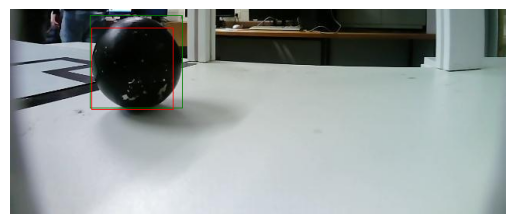

In [19]:
visu_tets(0)